# How to color your Map: The Good, the Bad and the Ugly
**An example using TUWien Surface Soil Moisture developed for GHG-Kit**

![](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)

*Image from [wikipedia](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)*.

In [1]:
import xarray as xr

from pathlib import Path
from tuw_education_notebooks.view_monthly_ssm import view_monthly_ssm, load_cmap

RESOURCES = Path("data")

## Science and Art

Data visualization depends on art to convey stories from data through the combination of geometric objects and color with science. In the ideal case the information should be easily extractable from the visualization, but at the same time the scientific elements should be to the point accurate. The latter is important as false graphical representations can lead to wrong perception amd interpretation, which, in turn, leads to wrongful decision making. These mistakes can be made intentionally, and thus be fraudulent, but are more often innocent mistakes with potentially far reaching consequences. When plotting data on maps we have to consider even more aspects, like the geographic projection, grid types and mapping of variables as a third dimension to a suitable color space.

## TUWien Surface Soil Moisture developed for GHG-Kit

For the examples in this notebook we will use soil moisture developed for GHG-Kit. We will provide a short explanation of how this data is derived a the TU Wien. To retrieve surface soil moisture data we exploit the general linear relationship between Sentinel-1 microwave backscattering and soil moisture. The change detection method developed at TU Wien can be summarised in the most simple terms by calculating the driest and wettest condition within a time period and then relating the observed backscatter to retrieve the relative soil moisture or “wetness” in percent as shown in Figure 1.

![](assets/images/ssm_retrieval_change_detection.png)

*Figure 1: Change detection method for retrieving surface soil moisture.*

For the examples we will show a subset of data over Austria. In Austria, two prominent challenges for soil moisture occur, these include:

- Pronounced geometric effects from varying viewing angles due to the variable topography in and around the Alps.
- Strong vegetation cover over dense forests.

In the Soil Moisture Product developed for GHG-Kit we address these challenges, using **radio metric terrain-corrected backscatter** data to “flatten” the terrain and static spatial filtering of **dense vegetation** at high resolution (See Supplement).

In the following lines we load a subset of the soil moisture dataset with `xarray`, which is stored as an Zarr archive.

In [2]:
SSM_dc = xr.open_zarr(RESOURCES / "SSM-CD-SIG40-R-DVEG_2018.zarr/")
SSM_dc

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 723, y: 1200, x: 1200)
Coordinates:
  * time         (time) datetime64[ns] 6kB 2018-01-01T05:08:47 ... 2018-12-31...
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
Data variables:
    band_data    (time, y, x) float64 8GB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    spatial_ref  int64 8B ...

We resample this dataset along the time dimension thereby aggregating surface soil moisture as mean values over months.

In [3]:
SSM_dc_monthly = SSM_dc.resample(time="ME").mean()
SSM_dc_monthly

<xarray.Dataset> Size: 138MB
Dimensions:      (time: 12, y: 1200, x: 1200)
Coordinates:
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
  * time         (time) datetime64[ns] 96B 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    band_data    (time, y, x) float64 138MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    spatial_ref  (time) int64 96B 0 0 0 0 0 0 0 0 0 0 0 0

## How (not) to color your Map

Now we are ready to plot the soil moisture data on a map. To plot one variable like soil moisture on the x (longitude) and y (latitude) dimensions requires finding a good representation in a 3D colorspace. This is also referred to as pseudocoloring: a method for revealing aspects of the data over a continuous plane. For effective pseudocoloring we need to find the correct colormap.  We can asks our selves the following questions:

- What do we know about the data. Is there e.g. a critical value to which compare the data?
- Is there a intuitive color scheme that nicely translates to the variable including the distribution of the data.

We can choose from the following types of colormaps:

- Sequential: steps in the variable space are equal to steps in color space (uniform colormaps).
- Diverging: if we have a critical middle value to which we want to compare the data.
- Cyclic: changes in lightness and/or two colors that meet in the middle. This is useful for when values wrap around the endpoints, such as phase angle, wind direction, or time of day.
- Qualitative: if we have unordered categorical data.

## The Bad

In the following maps we can see what can go wrong when don't take these aspects into consideration.

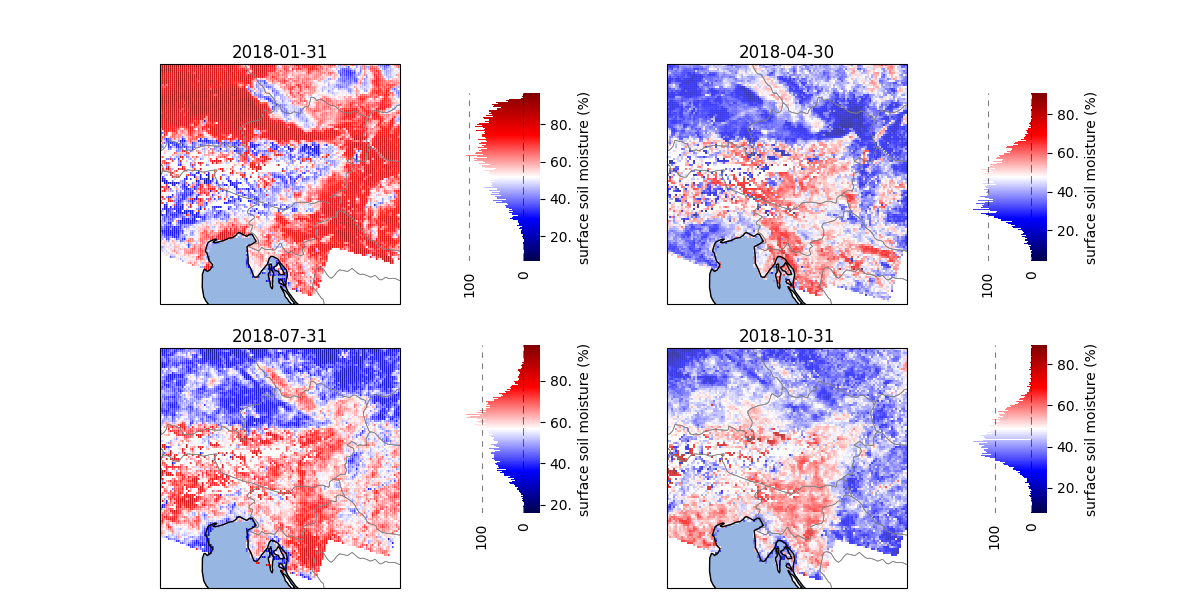

In [4]:
view_monthly_ssm(SSM_dc_monthly, "seismic")

*Figure 2: Monthly aggregated surface soil moisture (%) for January, April, July and October of 2018 retrieved with the TU Wien algorithm developed for the GHG-Kit project. Maps created with EOmaps (Quast 2024).*

What went wrong in the above maps? The first mistake is that we took a diverging colormap, although the data does not have a critical middle value. The sharp contrast between the blue an red further make it appear as if the data is binary, but in reality we have uniformly spaced values from a sample distribution that approximates a normal distribution (as can be seen form the histograms). On top of that, we have picked a colormap which includes white. There is also information in what we don't see on these map: e.g. missing data points. But by choosing to include white we give the false impression of missing data where we actually have a soil moisture saturation of 50%.

## The Ugly

Let's fix the first problem. We do this by choosing the sequential "viridis" colormap. In this colormap the color is a linear function of the variable with a very wide perceptual range (e.g. it is very colorful). Viridis is, furthermore, colorblindness friendly and prints well in grayscale whilst preserving perceptual uniformity and breadth of the range.


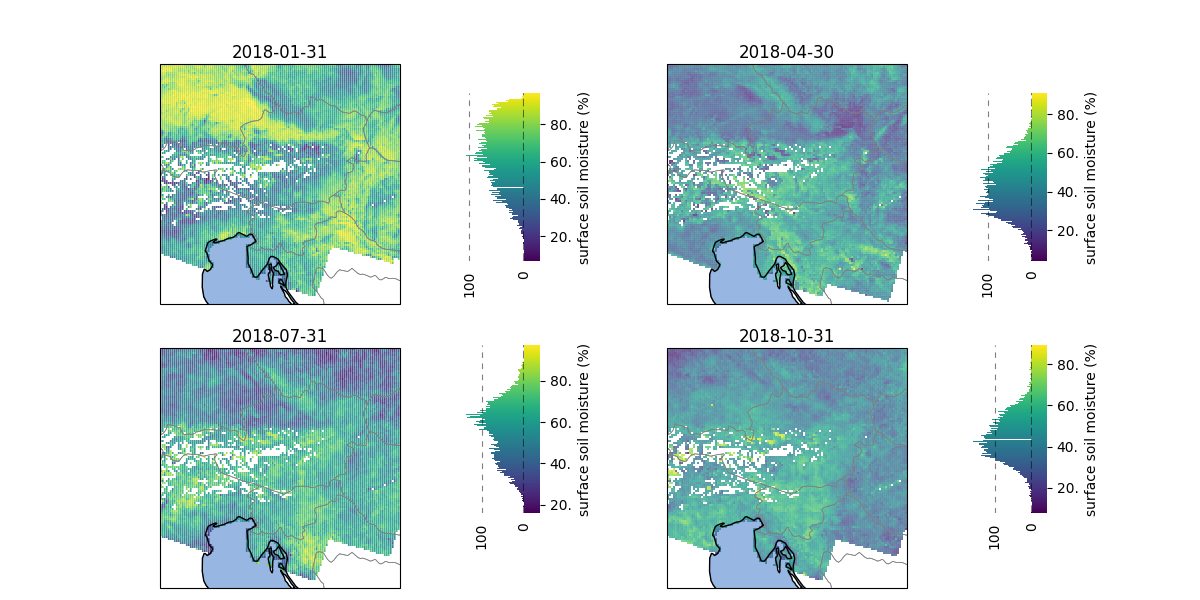

In [5]:
view_monthly_ssm(SSM_dc_monthly, "viridis")

*Figure 3: Monthly aggregated surface soil moisture (%) for January, April, July and October of 2018 retrieved with the TU Wien algorithm developed for the GHG-Kit project. Maps created with EOmaps (Quast 2024).*

This colormap fixes the previous issues. We see much more nuance in the variance of soil moisture. Foremost we also see that we have actual missing data points. There is a whole area in the Alps that is not well covered. This is actually a well known effect of the measurement technique. In contrast to some of our previous statements, we cannot address all geometric effects with radiometric terrain correction in microwave remote sensing. In very steep regions like the Alps, we still have to mask the data due to shadowing and layover effects. Shadowing occurs when the terrain is so steep that it blocks the view of subsequent points, preventing any measurements and obstructing scene reconstruction (See supplementary Figure 1). 

## The Good

This last step is more subjective and relates to the psychology of colors: the multiple meanings and feelings that people associated with a color. Here we use a linear color gradient developed by TU Wien from brown for dry soils to blue for wet soils.

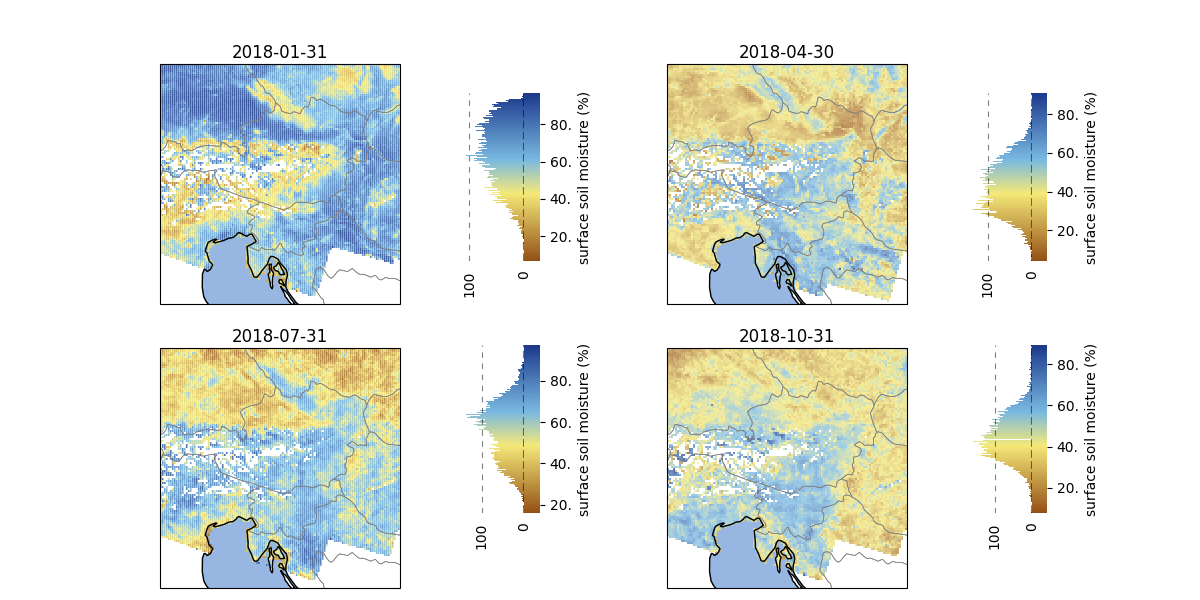

In [6]:
SSM_CMAP = load_cmap(RESOURCES / "colour-tables/ssm-continuous.ct")
view_monthly_ssm(SSM_dc_monthly, SSM_CMAP)

*Figure 4: Monthly aggregated surface soil moisture (%) for January, April, July and October of 2018 retrieved with the TU Wien algorithm developed for the GHG-Kit project. Maps created with EOmaps (Quast 2024).*

In this last rendition of the maps we have a nice linear relation between color and soil moisture. Where the brown color evokes images of dried-out soils and the blues of water saturated conditions.

## Supplement

### Radiometric Terrain Correction
Microwave backscatter has a strong dependency on the viewing angle, meaning that the backscatter measured varies a lot depending on the angle we are a looking at the ground. The incident angle under which the ground is viewed from a Sentinel-1 sensor, depends on its orbit. To correct for this, Bauer-Marschallinger et al. developed a method to normalise to a common incident angle of 40 degrees. However, this method assumes relatively flat topography and can fail in steep and varied terrain. Therefore, we use a high-resolution digital elevation model (DEM) to correct the backscatter at high resolution before up-sampling to 500 meters and normalizing to the common incident angle.

### Dense Vegetation Filtering
Dense vegetation can obstruct the signal from the soil, or it might be so weak that it’s indistinguishable from noise. To amplify the signal over densely vegetated areas Massart et al. developed a spatial filtering method to mask dense vegetation at high resolution before up-sampling to 500 m. By doing this the 500 m pixel contains a stronger signal from the soil, facilitating easier soil moisture retrieval. Improvements in agreement with modeled soil moisture from ERA5-Land are shown in figure  3, demonstrating strong improvements in agreement over Austria.


#### Shadowing and Layover
Layover occurs because microwave radar measures the distance between the sensor and a point on the ground. In very steep and high terrain, the terrain is “closer” to the sensor, shortening the measured distance and causing the point to appear before others in the raster. Both concepts are illustrated in supplementary figure 1:

![](assets/images/geometric_effects_backscattering.png)

*Figure 1: Schematic representation of shadowing and foreshortening during backscattering on topographic complex terrain.*

## References

Quast Raphael. 2024. "EOmaps" [Computer software]. [https://eomaps.readthedocs.io/en/latest/index.html](https://eomaps.readthedocs.io/en/latest/index.html)